In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
from tensorflow.keras.optimizers import Adam

2025-10-16 10:10:37.289816: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 10:10:37.481498: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 10:10:38.032847: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train / 127.5 - 1
X_train = np.expand_dims(X_train, axis=-1)
print("Training data shape:", X_train.shape)

Training data shape: (60000, 28, 28, 1)


In [3]:
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(28*28*1, activation='tanh'))
    model.add(Reshape((28,28,1)))
    return model

def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model


In [4]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential([generator, discriminator])
    return model


In [5]:
def train_gan(epochs, batch_size, latent_dim):
    # Prepare models
    generator = build_generator(latent_dim)
    discriminator = build_discriminator((28,28,1))
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    
    gan = build_gan(generator, discriminator)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    
    half_batch = batch_size // 2
    
    for epoch in range(epochs):
        # ---------------------
        # Train Discriminator
        # ---------------------
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_imgs = X_train[idx]
        
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_imgs = generator.predict(noise)
        
        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((half_batch,1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((half_batch,1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # ---------------------
        # Train Generator
        # ---------------------
        noise = np.random.normal(0,1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size,1)))
        
        if (epoch+1) % (epochs//10) == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} | D loss: {d_loss[0]:.4f}, D acc: {d_loss[1]*100:.2f}% | G loss: {g_loss:.4f}")
    
    # Generate final images
    noise = np.random.normal(0,1, (25, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0,1] for visualization
    
    # Plot generated images
    fig, axs = plt.subplots(5,5, figsize=(5,5))
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    
    # Save generated dataset
    np.save(f"generated_images_epochs{epochs}_latent{latent_dim}.npy", gen_imgs)



Training GAN with latent_dim=20 and epochs=100


2025-10-16 10:11:21.763173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-16 10:11:21.993254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-16 10:11:21.997895: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

1/1 [==============================] - 0s 143ms/step


2025-10-16 10:11:22.463505: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-10-16 10:11:22.778333: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x791a70ee0cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-16 10:11:22.778350: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-10-16 10:11:22.822987: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-16 10:11:22.874418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-10-16 10:11:23.003851: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

Epoch 1/100 | D loss: 0.8408, D acc: 21.88% | G loss: 0.6973
1/1 [==============================] - 0s 12ms/step
Epoch 10/100 | D loss: 0.1855, D acc: 98.44% | G loss: 1.0178
1/1 [==============================] - 0s 12ms/step
Epoch 20/100 | D loss: 0.1485, D acc: 98.44% | G loss: 1.9563
1/1 [==============================] - 0s 12ms/step
Epoch 30/100 | D loss: 0.0638, D acc: 100.00% | G loss: 2.6196
1/1 [==============================] - 0s 13ms/step
Epoch 40/100 | D loss: 0.0476, D acc: 100.00% | G loss: 3.2026
1/1 [==============================] - 0s 12ms/step
Epoch 50/100 | D loss: 0.0324, D acc: 100.00% | G loss: 3.2772
1/1 [==============================] - 0s 13ms/step
Epoch 60/100 | D loss: 0.0268, D acc: 100.00% | G loss: 3.6609
1/1 [==============================] - 0s 12ms/step
Epoch 70/100 | D loss: 0.0242, D acc: 100.00% | G loss: 3.6941
1/1 [==============================] - 0s 13ms/step
Epoch 80/100 | D loss: 0.0296, D acc: 100.00% | G loss: 3.8577
1/1 [================

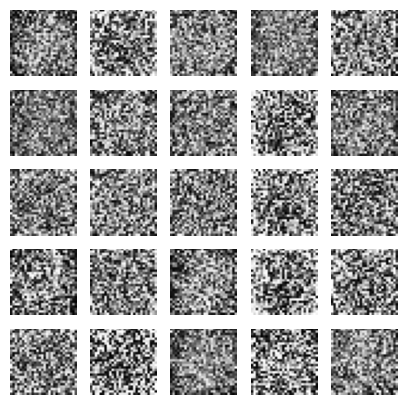


Training GAN with latent_dim=20 and epochs=150
1/1 [==============================] - 0s 49ms/step
Epoch 1/150 | D loss: 0.7899, D acc: 20.31% | G loss: 0.6899
1/1 [==============================] - 0s 12ms/step
Epoch 15/150 | D loss: 0.1467, D acc: 100.00% | G loss: 1.4918
1/1 [==============================] - 0s 12ms/step
Epoch 30/150 | D loss: 0.0654, D acc: 100.00% | G loss: 2.7561
1/1 [==============================] - 0s 13ms/step
Epoch 45/150 | D loss: 0.0374, D acc: 100.00% | G loss: 3.3117
1/1 [==============================] - 0s 12ms/step
Epoch 60/150 | D loss: 0.0310, D acc: 100.00% | G loss: 3.4352
1/1 [==============================] - 0s 13ms/step
Epoch 75/150 | D loss: 0.0206, D acc: 100.00% | G loss: 3.8443
1/1 [==============================] - 0s 12ms/step
Epoch 90/150 | D loss: 0.0241, D acc: 100.00% | G loss: 3.6517
1/1 [==============================] - 0s 12ms/step
Epoch 105/150 | D loss: 0.0281, D acc: 100.00% | G loss: 3.8001
1/1 [============================

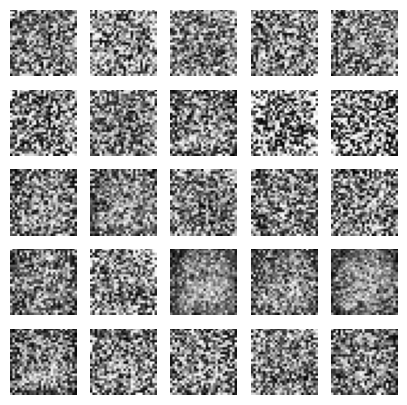


Training GAN with latent_dim=20 and epochs=200
1/1 [==============================] - 0s 48ms/step
Epoch 1/200 | D loss: 0.7392, D acc: 43.75% | G loss: 0.5563
1/1 [==============================] - 0s 12ms/step
Epoch 20/200 | D loss: 0.1138, D acc: 100.00% | G loss: 2.0268
1/1 [==============================] - 0s 12ms/step
Epoch 40/200 | D loss: 0.0395, D acc: 100.00% | G loss: 3.0932
1/1 [==============================] - 0s 12ms/step
Epoch 60/200 | D loss: 0.0651, D acc: 98.44% | G loss: 3.4263
1/1 [==============================] - 0s 12ms/step
Epoch 80/200 | D loss: 0.0483, D acc: 98.44% | G loss: 3.6274
1/1 [==============================] - 0s 12ms/step
Epoch 100/200 | D loss: 0.0651, D acc: 98.44% | G loss: 4.0562
1/1 [==============================] - 0s 12ms/step
Epoch 120/200 | D loss: 0.0439, D acc: 100.00% | G loss: 3.9467
1/1 [==============================] - 0s 12ms/step
Epoch 140/200 | D loss: 0.0512, D acc: 100.00% | G loss: 3.9749
1/1 [=============================

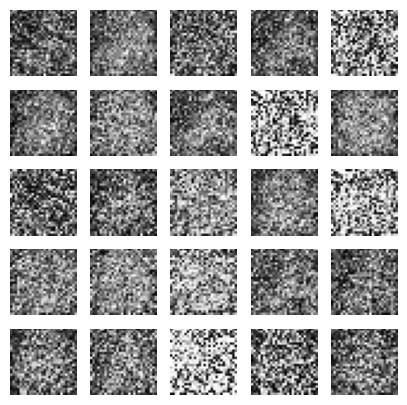


Training GAN with latent_dim=50 and epochs=100
1/1 [==============================] - 0s 76ms/step
Epoch 1/100 | D loss: 0.5230, D acc: 81.25% | G loss: 0.4790
1/1 [==============================] - 0s 12ms/step
Epoch 10/100 | D loss: 0.1871, D acc: 100.00% | G loss: 1.3307
1/1 [==============================] - 0s 12ms/step
Epoch 20/100 | D loss: 0.0655, D acc: 100.00% | G loss: 2.6481
1/1 [==============================] - 0s 12ms/step
Epoch 30/100 | D loss: 0.0323, D acc: 100.00% | G loss: 3.1745
1/1 [==============================] - 0s 12ms/step
Epoch 40/100 | D loss: 0.0255, D acc: 100.00% | G loss: 3.3874
1/1 [==============================] - 0s 12ms/step
Epoch 50/100 | D loss: 0.0162, D acc: 100.00% | G loss: 3.7006
1/1 [==============================] - 0s 16ms/step
Epoch 60/100 | D loss: 0.0200, D acc: 100.00% | G loss: 3.9548
1/1 [==============================] - 0s 12ms/step
Epoch 70/100 | D loss: 0.0222, D acc: 100.00% | G loss: 4.1131
1/1 [=============================

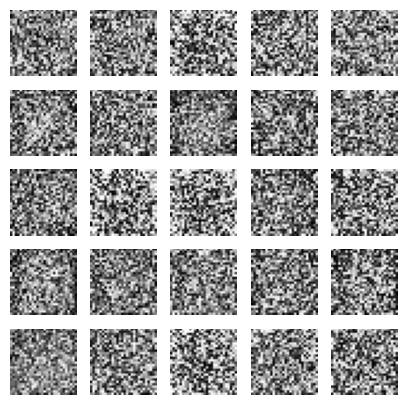


Training GAN with latent_dim=50 and epochs=150
1/1 [==============================] - 0s 53ms/step
Epoch 1/150 | D loss: 0.7704, D acc: 23.44% | G loss: 0.5239
1/1 [==============================] - 0s 12ms/step
Epoch 15/150 | D loss: 0.1795, D acc: 100.00% | G loss: 1.6611
1/1 [==============================] - 0s 12ms/step
Epoch 30/150 | D loss: 0.0482, D acc: 100.00% | G loss: 2.6818
1/1 [==============================] - 0s 12ms/step
Epoch 45/150 | D loss: 0.0259, D acc: 100.00% | G loss: 3.1887
1/1 [==============================] - 0s 12ms/step
Epoch 60/150 | D loss: 0.0260, D acc: 100.00% | G loss: 3.5228
1/1 [==============================] - 0s 12ms/step
Epoch 75/150 | D loss: 0.0189, D acc: 100.00% | G loss: 3.8346
1/1 [==============================] - 0s 13ms/step
Epoch 90/150 | D loss: 0.0247, D acc: 100.00% | G loss: 4.0058
1/1 [==============================] - 0s 12ms/step
Epoch 105/150 | D loss: 0.0329, D acc: 100.00% | G loss: 3.9972
1/1 [============================

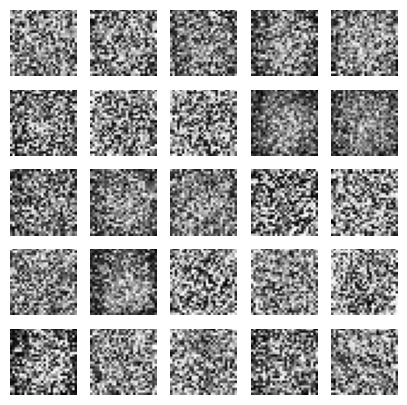


Training GAN with latent_dim=50 and epochs=200
1/1 [==============================] - 0s 48ms/step
Epoch 1/200 | D loss: 0.5960, D acc: 50.00% | G loss: 0.4059
1/1 [==============================] - 0s 12ms/step
Epoch 20/200 | D loss: 0.0854, D acc: 100.00% | G loss: 2.2844
1/1 [==============================] - 0s 13ms/step
Epoch 40/200 | D loss: 0.0233, D acc: 100.00% | G loss: 3.2153
1/1 [==============================] - 0s 13ms/step
Epoch 60/200 | D loss: 0.0201, D acc: 100.00% | G loss: 3.6557
1/1 [==============================] - 0s 12ms/step
Epoch 80/200 | D loss: 0.0163, D acc: 100.00% | G loss: 3.9105
1/1 [==============================] - 0s 13ms/step
Epoch 100/200 | D loss: 0.0228, D acc: 100.00% | G loss: 4.1846
1/1 [==============================] - 0s 12ms/step
Epoch 120/200 | D loss: 0.0194, D acc: 100.00% | G loss: 4.2722
1/1 [==============================] - 0s 12ms/step
Epoch 140/200 | D loss: 0.0494, D acc: 96.88% | G loss: 3.9222
1/1 [===========================

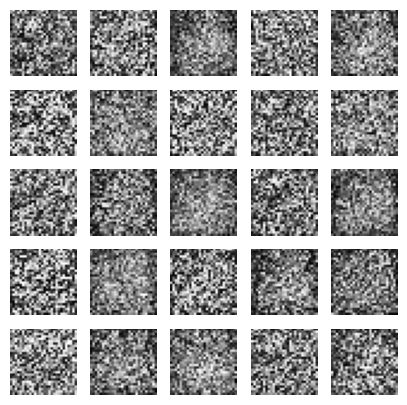


Training GAN with latent_dim=100 and epochs=100
1/1 [==============================] - 0s 50ms/step
Epoch 1/100 | D loss: 0.5891, D acc: 79.69% | G loss: 0.5726
1/1 [==============================] - 0s 13ms/step
Epoch 10/100 | D loss: 0.1807, D acc: 98.44% | G loss: 1.3340
1/1 [==============================] - 0s 12ms/step
Epoch 20/100 | D loss: 0.0634, D acc: 100.00% | G loss: 2.4820
1/1 [==============================] - 0s 12ms/step
Epoch 30/100 | D loss: 0.0340, D acc: 100.00% | G loss: 2.9996
1/1 [==============================] - 0s 13ms/step
Epoch 40/100 | D loss: 0.0306, D acc: 100.00% | G loss: 3.3381
1/1 [==============================] - 0s 14ms/step
Epoch 50/100 | D loss: 0.0220, D acc: 100.00% | G loss: 3.5014
1/1 [==============================] - 0s 12ms/step
Epoch 60/100 | D loss: 0.0147, D acc: 100.00% | G loss: 3.8134
1/1 [==============================] - 0s 12ms/step
Epoch 70/100 | D loss: 0.0161, D acc: 100.00% | G loss: 3.9692
1/1 [=============================

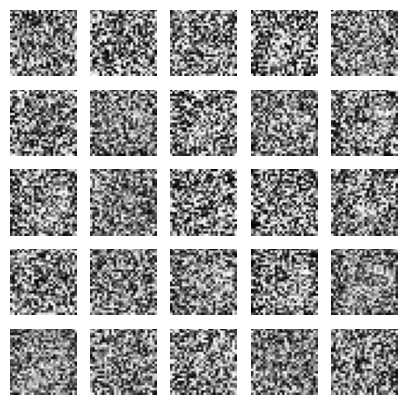


Training GAN with latent_dim=100 and epochs=150
1/1 [==============================] - 0s 47ms/step
Epoch 1/150 | D loss: 0.7380, D acc: 35.94% | G loss: 0.7778
1/1 [==============================] - 0s 12ms/step
Epoch 15/150 | D loss: 0.0931, D acc: 100.00% | G loss: 2.1779
1/1 [==============================] - 0s 12ms/step
Epoch 30/150 | D loss: 0.0352, D acc: 100.00% | G loss: 3.0392
1/1 [==============================] - 0s 12ms/step
Epoch 45/150 | D loss: 0.0270, D acc: 100.00% | G loss: 3.4480
1/1 [==============================] - 0s 12ms/step
Epoch 60/150 | D loss: 0.0203, D acc: 100.00% | G loss: 3.7405
1/1 [==============================] - 0s 12ms/step
Epoch 75/150 | D loss: 0.0184, D acc: 100.00% | G loss: 4.0056
1/1 [==============================] - 0s 15ms/step
Epoch 90/150 | D loss: 0.0175, D acc: 100.00% | G loss: 4.2006
1/1 [==============================] - 0s 15ms/step
Epoch 105/150 | D loss: 0.0175, D acc: 100.00% | G loss: 4.4136
1/1 [===========================

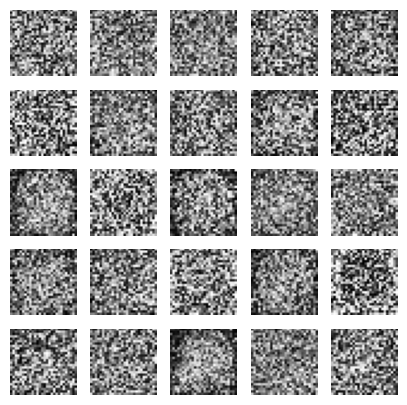


Training GAN with latent_dim=100 and epochs=200
1/1 [==============================] - 0s 50ms/step
Epoch 1/200 | D loss: 0.7773, D acc: 51.56% | G loss: 0.6954
1/1 [==============================] - 0s 12ms/step
Epoch 20/200 | D loss: 0.0852, D acc: 100.00% | G loss: 2.2854
1/1 [==============================] - 0s 12ms/step
Epoch 40/200 | D loss: 0.0255, D acc: 100.00% | G loss: 3.2958
1/1 [==============================] - 0s 13ms/step
Epoch 60/200 | D loss: 0.0199, D acc: 100.00% | G loss: 3.7059
1/1 [==============================] - 0s 13ms/step
Epoch 80/200 | D loss: 0.0191, D acc: 100.00% | G loss: 4.0049
1/1 [==============================] - 0s 12ms/step
Epoch 100/200 | D loss: 0.0164, D acc: 100.00% | G loss: 4.2287
1/1 [==============================] - 0s 12ms/step
Epoch 120/200 | D loss: 0.0223, D acc: 100.00% | G loss: 4.3090
1/1 [==============================] - 0s 12ms/step
Epoch 140/200 | D loss: 0.0181, D acc: 100.00% | G loss: 4.3093
1/1 [=========================

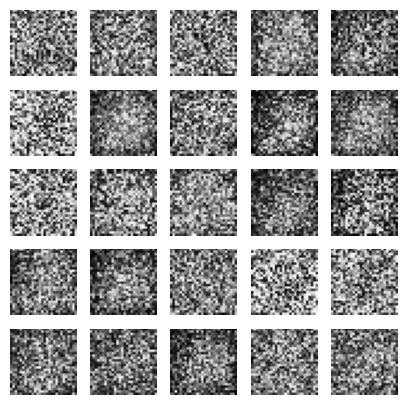

In [6]:
latent_dims = [20, 50, 100]
epochs_list = [100, 150, 200]

for latent_dim in latent_dims:
    for epochs in epochs_list:
        print(f"\nTraining GAN with latent_dim={latent_dim} and epochs={epochs}")
        train_gan(epochs=epochs, batch_size=64, latent_dim=latent_dim)


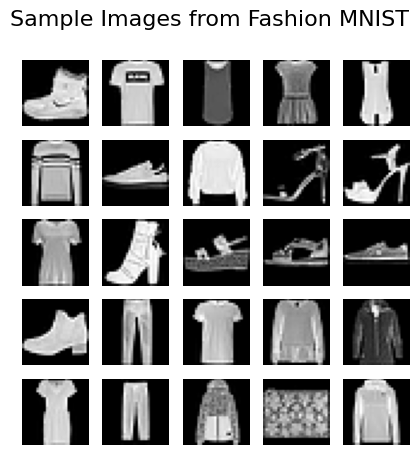

In [7]:
# Plot 25 random images from Fashion MNIST
plt.figure(figsize=(5,5))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i,:,:,0] * 0.5 + 0.5, cmap='gray')  # Rescale from [-1,1] to [0,1]
    plt.axis('off')
plt.suptitle("Sample Images from Fashion MNIST", fontsize=16)
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# Load and preprocess Fashion MNIST
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

BUFFER_SIZE = 60000

# Batch and shuffle the data
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def build_generator(latent_dim):
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Training function
@tf.function
def train_step(images, generator, discriminator, generator_optimizer, discriminator_optimizer, latent_dim):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs, latent_dim, save_dir):
    generator = build_generator(latent_dim)
    discriminator = build_discriminator()

    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

    seed = tf.random.normal([16, latent_dim])

    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, generator, discriminator, generator_optimizer, discriminator_optimizer, latent_dim)

        print(f'Epoch {epoch+1}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}')
        if (epoch + 1) % 50 == 0 or epoch == 0:
            generate_and_save_images(generator, epoch + 1, seed, save_dir)

    # Generate final images after training
    generate_and_save_images(generator, epochs, seed, save_dir)
    return generator

def generate_and_save_images(model, epoch, test_input, save_dir):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f'{save_dir}/image_at_epoch_{epoch:04d}.png')
    plt.close(fig)

# Experiment with different epochs and latent_dims
epochs_list = [100, 150, 200]
latent_dims = [20, 50, 100]

for latent_dim in latent_dims:
    for epochs in epochs_list:
        print(f'Training GAN with latent_dim={latent_dim}, epochs={epochs}')
        save_dir = f'gan_outputs/latent_{latent_dim}_epochs_{epochs}'
        gen_model = train(train_dataset, epochs, latent_dim, save_dir)


Training GAN with latent_dim=20, epochs=100


2025-10-16 10:17:33.265427: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_28/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-10-16 10:17:40.338515: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_28/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1, Gen Loss: 0.7417677640914917, Disc Loss: 1.2816970348358154
Epoch 2, Gen Loss: 0.9247316122055054, Disc Loss: 1.1049737930297852
Epoch 3, Gen Loss: 0.702101469039917, Disc Loss: 1.4482600688934326
Epoch 4, Gen Loss: 0.5907512307167053, Disc Loss: 1.5102205276489258
Epoch 5, Gen Loss: 0.8121970891952515, Disc Loss: 1.37897527217865
Epoch 6, Gen Loss: 0.7012239694595337, Disc Loss: 1.4601300954818726
Epoch 7, Gen Loss: 0.8403363823890686, Disc Loss: 1.2396495342254639
Epoch 8, Gen Loss: 0.9651621580123901, Disc Loss: 1.2774808406829834
Epoch 9, Gen Loss: 0.7969041466712952, Disc Loss: 1.2966868877410889
Epoch 10, Gen Loss: 0.8972960114479065, Disc Loss: 1.1076432466506958
Epoch 11, Gen Loss: 0.865379810333252, Disc Loss: 1.241448163986206
Epoch 12, Gen Loss: 0.7590610384941101, Disc Loss: 1.4279675483703613
Epoch 13, Gen Loss: 0.8285349607467651, Disc Loss: 1.2982120513916016
Epoch 14, Gen Loss: 0.892056405544281, Disc Loss: 1.3180277347564697
Epoch 15, Gen Loss: 1.0302662849426